# EfficientNet + Transformers
A ideia agora é utilizar uma rede pré-treinada como extratora de características dos frames dos vídeos.

Em um primeiro momento, trabalharemos com a *EfficientNet* extraindo informações de N frames de vídeos. O tensor informações será então processado por uma rede de arquitetura *Transformers* para prever se a pessoa do vídeo é extrovertida ou não-extrovertida.

## Extrovertidos *vs* Não-Extrovertidos
Para uma primeira análise da aplicabilidade do modelo, iremos dividir as pessoas dos vídeos em **Extrovertidas** e **Não-Extrovertidas**. Para isso, analisando o rótulo *extraverssion*, classifcaremos o primeiro quartil como **Não-Extrovertido** e último quartil como **Extrovertido**. 

### Adaptando o *Dataset*

In [4]:
data_path = "./chalearn_dataset"

In [78]:
import pandas as pd

data_training = pd.read_pickle(f"{data_path}/train/annotation_training.pkl")
df_training = pd.DataFrame.from_dict(data_training)

df_training.head(5)

,extraversion,neuroticism,agreeableness,conscientiousness,interview,openness
J4GQm9j0JZ0.003.mp4,0.523364,0.552083,0.626374,0.601942,0.504673,0.488889
zEyRyTnIw5I.005.mp4,0.345794,0.375000,0.472527,0.582524,0.457944,0.366667
nskJh7v6v1U.004.mp4,0.252336,0.291667,0.406593,0.485437,0.373832,0.511111
6wHQsN5g2RM.000.mp4,0.457944,0.489583,0.505495,0.398058,0.457944,0.377778
dQOeQYWIgm8.000.mp4,0.607477,0.489583,0.406593,0.621359,0.570093,0.622222


In [37]:
df_training.describe()

,extraversion,neuroticism,agreeableness,conscientiousness,interview,openness
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.476146,0.520286,0.548181,0.522731,0.503780,0.566281
std,0.152297,0.153546,0.136385,0.155219,0.150148,0.146990
min,0.000000,0.020833,0.000000,0.000000,0.000000,0.000000
25%,0.373832,0.416667,0.461538,0.417476,0.401869,0.466667
50%,0.476636,0.531250,0.560440,0.524272,0.514019,0.577778
75%,0.588785,0.635417,0.637363,0.631068,0.609813,0.666667
max,0.925234,0.979167,1.000000,0.970874,1.000000,1.000000


In [79]:
# Descobrir os primeiro e terceiro quartis
label = 'extraversion'

df_quartiles = df_training.quantile([0.25, 0.75])
quartile1 = df_quartiles[label][0.25]
quartile3 = df_quartiles[label][0.75]

print(f"Primeiro Quartil: {quartile1}\nTerceiro Quartil: {quartile3}")

Primeiro Quartil: 0.37383177570093457
Terceiro Quartil: 0.588785046728972


In [80]:
# Cria um novo DataSet com apenas o primeiro quartil
df1 = df_training[df_training[label] <= quartile1][[label]].copy()
# df1[label] = 0 # Seta o último quartil como Não-Extrovertido
df1.describe()

,extraversion
count,1613.000000
mean,0.285432
std,0.073792
min,0.000000
25%,0.242991
50%,0.299065
75%,0.345794
max,0.373832


In [81]:
# Cria um novo DataSet com apenas o terceiro quartil
df3 = df_training[df_training[label] >= quartile3][[label]].copy()
# df3[label] = 1 # Seta o último quartil como Não-Extrovertido
df3.describe()

,extraversion
count,1505.000000
mean,0.668550
std,0.063550
min,0.588785
25%,0.616822
50%,0.654206
75%,0.710280
max,0.925234


In [88]:
df1[label] = 0 # Primeiro quartil recebe 0: Não-Extrovertido
df3[label] = 1 # Terceiro quartil recebe 1: Extrovertido
# df_training = df1 + df3 # Novo DataSet de treinamento
df_training = pd.concat([df1, df3])
df_training.describe()

,extraversion
count,3118.000000
mean,0.482681
std,0.499780
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


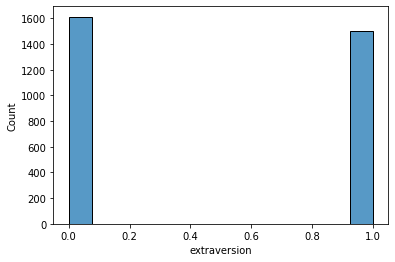

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
  
  
sns.histplot(x='extraversion', data=df_training, )
plt.show()

Agora nós temos um Dataframe, ```df_training``` com vídeos classificados em **Extrovetidos**, 1, e **Não-Extrovertidos**, 0.